In [2]:
import os
os.getcwd()

'/home/david/Documents/ml_projects/autoencoder/preprocess'

In [20]:
import h5py
path_to_file = "/home/david/Documents/ml_projects/autoencoder/afm_patches_256.h5"

with h5py.File(path_to_file, "r") as f:
    def visit(name, obj):
        print(name, obj.shape if hasattr(obj, "shape") else "")
    f.visititems(visit)


patches 
patches/proc (404, 256, 256)
patches/raw (404, 256, 256)
patches/source_file (404,)
patches/top_left_yx (404, 2)
scans 
scans/meta_jsonl (86,)


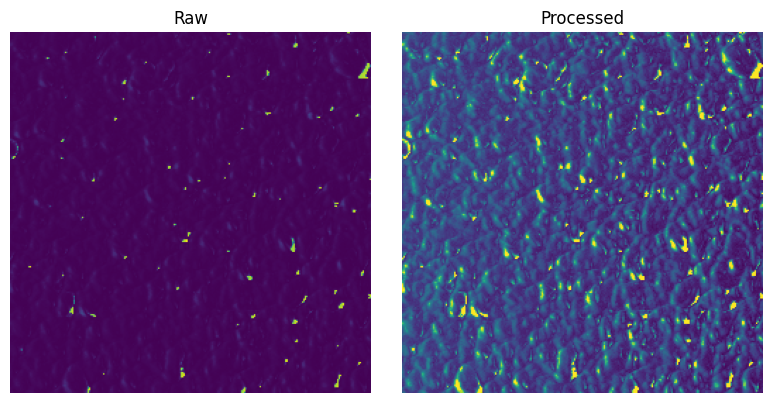

In [21]:
import numpy as np
import matplotlib.pyplot as plt

with h5py.File(path_to_file ,"r") as f:
    raw = f["patches/raw"]
    proc = f["patches/proc"]

    idx = np.random.randint(0, raw.shape[0])

    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].imshow(raw[idx], )
    ax[0].set_title("Raw")
    ax[1].imshow(proc[idx], )
    ax[1].set_title("Processed")

    for a in ax:
        a.axis("off")

    plt.tight_layout()
    plt.show()


## Check statistics

In [23]:
with h5py.File(path_to_file , "r") as f:
    proc = f["patches/proc"]

    print("mean:", proc[:1000].mean())
    print("std :", proc[:1000].std())
    print("min :", proc[:1000].min())
    print("max :", proc[:1000].max())


mean: 1.4840934e-09
std : 2.9793172e-08
min : -5.7268926e-07
max : 4.9044036e-07


## Patch providence

In [24]:
with h5py.File(path_to_file, "r") as f:
    src = f["patches/source_file"]
    yx  = f["patches/top_left_yx"]

    i = np.random.randint(0, len(src))
    print("Patch", i)
    print("Source file:", src[i])
    print("Top-left (y, x):", yx[i])


Patch 246
Source file: b'data/data_gwy/samples070425_3_PHASE SHIFT.gwy'
Top-left (y, x): [0 0]


## Reconstruct full scan

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

file_to_check = "/home/david/Documents/ml_projects/autoencoder/data/data_gwy/perovskite_s101024_14_30_T.gwy"

with h5py.File(path_to_file, "r") as f:
    raw = f["patches/raw"]
    src = f["patches/source_file"]
    yx  = f["patches/top_left_yx"]

    idxs = [i for i in range(len(src)) if src[i] == file_to_check]

    if not idxs:
        raise ValueError("No patches found for file")

    # Get scan size from metadata (simplest: infer bounding box)
    ys = [yx[i][0] for i in idxs]
    xs = [yx[i][1] for i in idxs]

    H = max(ys) + 256
    W = max(xs) + 256

    recon = np.zeros((H, W), dtype=np.float32)

    for i in idxs:
        y, x = yx[i]
        recon[y:y+256, x:x+256] = raw[i]

plt.imshow(recon, cmap="gray")
plt.title("Reconstructed raw scan")
plt.axis("off")
plt.show()


ValueError: No patches found for file

## MetaData

import json
import h5py

with h5py.File("afm_patches_256.h5", "r") as f:
    meta = f["scans/meta_jsonl"][0]
    print(json.loads(meta))
